# Tuner of Text Classifiers

In [6]:
import ipynb
from ipynb.fs.defs.data_collect_preprocessing1 import get_x_y_preprocessed
from ipynb.fs.defs.data_collect_preprocessing1 import get_one_hot
from ipynb.fs.defs.data_collect_preprocessing1 import CATEGORIES
from ipynb.fs.defs.data_collect_preprocessing1 import preprocess_text

import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer, Input, Dense, Embedding, Flatten, Dropout
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Conv1D, Bidirectional, GRU, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import sys
# from tqdm import tqdm
import os
from tqdm.notebook import tqdm
from scipy import stats
# pip install -q -U keras-tuner
import keras_tuner as kt

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
print(CATEGORIES)

['sport', 'politics', 'economics', 'psychology', 'philosophy', 'literature', 'physics']


In [5]:
x_rec, y_rec = get_x_y_preprocessed("dataset_cat")

In [7]:
print("type x_rec: ", type(x_rec))
print("type y_rec: ", type(y_rec.shape))
print("x_rec: ", len(x_rec))
print("y_rec: ", y_rec.shape)

type x_rec:  <class 'list'>
type y_rec:  <class 'tuple'>
x_rec:  3341
y_rec:  (3341, 7)


In [8]:
print(x_rec[1000])
print(y_rec[1000])
print(CATEGORIES[np.argmax(y_rec[1000])])

['positive', 'relationship', 'increasing', 'point', 'f', ',', 'beyond', 'income', 'effect', 'dominates', 'substitution', 'effect', 'individual', 'starts', 'reduce', 'number', 'labour', 'hours', 'supplies', '(point', 'g)', 'wage', 'increases', ';', 'words', ',', 'wage', 'elasticity', 'negativethe', 'direction', 'slope', 'may', 'change', 'individuals', ',', 'labour', 'supply', 'curve', 'different', 'different', 'individualsother', 'variables', 'affect', 'labour', 'supply', 'decision', ',', 'readily', 'incorporated', 'model', ',', 'include', 'taxation', ',', 'welfare', ',', 'work', 'environment', ',', 'income', 'signal', 'ability', 'social', 'contribution']
[0. 0. 1. 0. 0. 0. 0.]
economics


In [10]:
EMBEDDING_DIM = 100
NUM_WORDS = 10000

In [11]:
tokenizer = Tokenizer(num_words=NUM_WORDS)
print(tokenizer.num_words)

10000


In [12]:
tokenizer.fit_on_texts(x_rec)

In [13]:
word_index = tokenizer.word_index

In [14]:
word_index["literature"]

15

In [15]:
print(type(word_index))

<class 'dict'>


In [16]:
sequences = tokenizer.texts_to_sequences(x_rec)

In [17]:
print(len(sequences))

3341


In [18]:
len_seq = [len(s)  for s in sequences]
len_seq = np.array(len_seq)

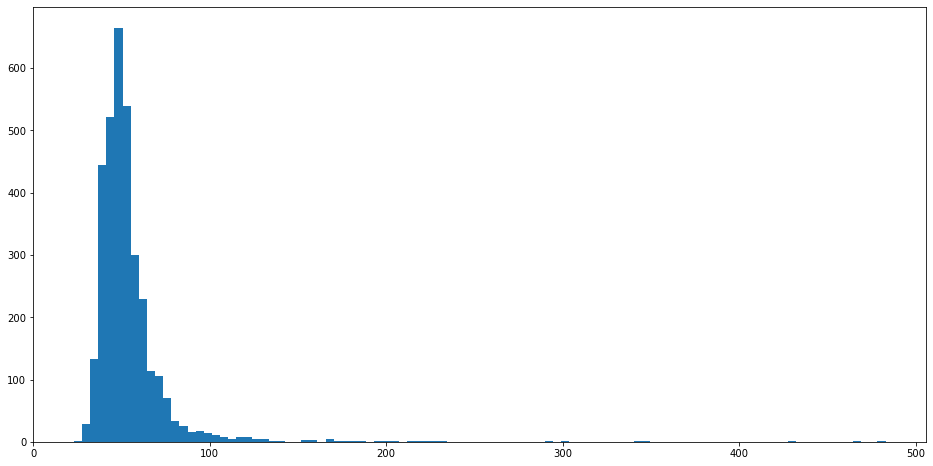

In [19]:
plt.figure(figsize=(16, 8))
plt.hist(len_seq, 100)
plt.show()

In [20]:

print("min:", len_seq.min())
print("mean:", len_seq.mean())
print("max", len_seq.max())
print("median", np.median(len_seq))
print("mode:", stats.mode(len_seq))
print("sigma:", np.std(len_seq))

PERCENTILE = 75
print(PERCENTILE, "percentile:", np.percentile(len_seq, PERCENTILE))
print("num over", PERCENTILE, "percentile:", np.count_nonzero(len_seq > np.percentile(len_seq, PERCENTILE))) 


min: 23
mean: 54.03023046991919
max 483
median 50.0
mode: ModeResult(mode=array([42]), count=array([143]))
sigma: 24.65488791236795
75 percentile: 58.0
num over 75 percentile: 773


In [21]:
SENTENCE_LENGTH = 60
print("Num sentence over SENTENCE_LENGTH:", np.count_nonzero(len_seq > SENTENCE_LENGTH)) 

Num sentence over SENTENCE_LENGTH: 655


In [22]:
x_num_fix = pad_sequences(sequences, maxlen=SENTENCE_LENGTH)  

In [23]:
x_num_fix[1000]

array([ 266,  539,  678,  116,  191,    1,  789,  485,  271, 5962, 3772,
        271,   91, 2282, 1005,   51,  202, 2267, 7718,  625, 1015,    7,
       1012,    1,  625, 2521,  516, 3740,   13,  175,  268,    1,  202,
        508, 1363,   45,   45, 1067,  764,  202,  508,  351,    1, 3750,
       2295,   89,    1,   31, 6023,    1, 2349,    1,   16,  403,    1,
        485, 3055,  437,   10, 1569])

In [24]:
X_train, X_test, y_train, y_test = train_test_split(x_num_fix, y_rec, test_size=0.20, random_state=42)  # dividiamo il dataset lasciando una parte (0.2 quindi 20%) per la validation


In [25]:
print(y_train[3])

[0. 0. 0. 0. 1. 0. 0.]


In [26]:
print("X_train: ", len(X_train))
print("y_train: ", y_train.shape)
print("X_test: ", len(X_test))
print("y_test: ", y_test.shape)

X_train:  2672
y_train:  (2672, 7)
X_test:  669
y_test:  (669, 7)


###  embedding glove

In [27]:
MY_EMBEDDING_PATH = "C:\\Users\\lpdepersiis\\PycharmProjects\\autoencoderNlp\\embedding\\en\\glove\\"


In [28]:
def get_word_matrix():
    """
    Questa funzione ci serve per crearci un dizionario avente come indice la parola e come valore il vettore dell'embedding corrispondente
    """
    word_matrix = {}
    with open(MY_EMBEDDING_PATH + 'glove.6B.100d.txt', 'r', encoding='UTF-8') as file_emb:
        lines = [line for line in file_emb]
        for row in tqdm(lines, total=len(lines)): # leggo ogni riga del file di testo contenente l'embedding
            row = row.split() # la divido nei suoi elementi
            word_matrix[row[0]] = np.array(row[1:], dtype='float32') # il primo è la parola e sarà l'indice di questa voce, gli altri andranno a formare il vettore 
    return word_matrix

In [29]:
word_matrix = get_word_matrix()

print(len(word_matrix))


400000


In [30]:
def get_embedding_matrix(embeddings_index, word_index, dim_embeddings=EMBEDDING_DIM, num_words=NUM_WORDS):
    """
    Tramite questa funzione creiamo una matrice in cui le righe siano nello stesso ordine dell'indice ottenuto dal tokenizer 
    e che contenga solo i vettori relativi alle parole in esso contenute
    
    :param embeddings_index: il dizionario, ottenuto dall'embedding, avente le parole come indice ed i vettori come valore
    :param word_index:  il dizionario ottenuto dal tokenizer avente come indice la parola e come valore il suo indice
    :param dim_embeddings: la lunghezza dei vettori dell'embedding che stiamo utilizzando
    :param num_words: il numero di parole più frequenti da utilizzare
    :return: la matrice dei vettori dell'embedding ordinata come il nostro indice

    """
    embedding_matrix = np.zeros((num_words + 1, dim_embeddings))  # creiamo la matrice di zeri avente tante righe quante sono le parole (più una) e tante colonne quante sono quelle dei vettori
    error_word = []
    for word in tqdm(word_index.keys(), total=num_words):  # Scorriamo le parole dell'indice del tokenizer
        if word_index[word] >= num_words:
            break
        embedding_vector = embeddings_index.get(word)  # estraiamo il vettore corrispondente
        if embedding_vector is not None:  # verifichiamo che esista (anche se il nostro dizionario è più piccolo di quello dell'embedding potrebbe contenere parolo non presenti in esso)
            # se la parola è presente andiamo avanti (se non è presente, in corrispondenza di questo indice, rimarrà il vettore formato da zeri)
            embedding_matrix[word_index[word]] = embedding_vector  # impostiamo nella matrice quella riga con il vettore corrispondente alla parola
        else:
            error_word.append(word)
    
    print(error_word)
    return embedding_matrix

In [31]:
word_index = tokenizer.word_index
embedding_matrix = get_embedding_matrix(word_matrix, word_index)


['', '{\\displaystyle', '"the', '⋅', '(or', '{\\frac', '−', '(the', '\\mathbf', '(e', "one's", '(such', '∫', '{x}', '(in', '\\cdot', "women's", '{f}', '(see', '˙', '{v}', '\\psi', '{\\mathbf', "master's", '\\int', '(i', '"a', '(also', "world's", '(and', '(a', '(as', "individual's", "keynes's", '{\\dot', 'ℏ', "country's", 'pressisbn', '\t\t', '}}', '{d}', '(including', 'bce)', "newton's", '(which', 'left–right', "school's", "aristotle's", "lse's", '(sometimes', "people's", 'mph)', 'csikszentmihályi', "party's", "eysenck's", '⟨', '⟩', "bbc's", '(from', '(who', '(for', '016/b978-0-08-097086-8', '\\delta', '(1', "men's", 'ccording', "plato's", "child's", 'vaiśeṣika', '{r}', 'work–energy', "sport's", '"political', '(with', 'bc)', 'nyāya', 'century)', "nobel's", '}}\\cdot', '\\phi', '\u2061', "bachelor's", '(us)', '→', '{\\omega', '_{t_{1}}^{t_{2}}\\mathbf', '(2', '(often', '"to', "person's", "kahn's", 'mīmāṃsā', 'literature"', 'a}', '{t}', '(usually', 'force)', 'centurythe', '"new', '"for'

In [32]:
print(embedding_matrix.shape)

(10001, 100)


In [33]:
def get_embedding_layer(embedding_matrix, input_length=SENTENCE_LENGTH, trainable=False):
    """
     Instanzia lo strato di tipo Embedding

    :param embedding_matrix: Il dizionario ottenuto dall'embedding avente le parole come indice e il vettore come valore
    :param input_length: La lunghezza delle frasi che saranno passate come input
    :param trainable: Se True i vettori partecipano all'addestramento e si modificano
    
    :return: lo strato di tipo Embedding
    """

    embedding_layer = Embedding(  # Creiamo un'istanza del layer di tipo Embedding ed impostiamo i parametri indispensabili e quelli necessari per le nostre esigenze
                        embedding_matrix.shape[0],  # il numero di righe (numero di parole + 1)
                        embedding_matrix.shape[1],  #  il numero di colonne (lunghezza dei vettori)
                        weights=[embedding_matrix],  # l'embedding_matrix creata tramite la funzione precedente
                        input_length=input_length,  # la lunghezza delle frasi
                        trainable=trainable)  # Impostiamo se questo strato deve essere addestrabile o meno, se lo impostiamo addestrabile i vettori si modificheranno

    return embedding_layer  # restituiamo lo strato Embedding




### Model builder


In [34]:
def model_builder(hp):
    
    LAYER_TYPE = hp.Choice("LAYER_TYPE", ["Dense", "Conv1D", "LSTM", "GRU"])
    TRAINABLE = hp.Boolean("TRAINABLE")
    UNITS_L1 = hp.Int('UNITS_L1', min_value=32, max_value=128, step=8)
    KERNEL_SIZE = hp.Int('KERNEL_SIZE', min_value=3, max_value=7, step=1)
    DROPOUT1 = hp.Float('DROPOUT1', min_value=0.05, max_value=0.5, step=0.05, default=0.3)
    DROPOUT2 = hp.Float('DROPOUT2', min_value=0.05, max_value=0.5, step=0.05, default=0.3)
    UNITS_L2 = hp.Int('UNITS_L2', min_value=32, max_value=128, step=8, default=128)
    DROPOUT3 = hp.Float('DROPOUT3', min_value=0.1, max_value=0.5, step=0.1, default=0.4)
    UNITS_L3 = hp.Int('UNITS_L3', min_value=32, max_value=128, step=8, default=64)
    DROPOUT4 = hp.Float('DROPOUT4', min_value=0.1, max_value=0.5, step=0.1, default=0.4)
    UNITS_L4 = hp.Int('UNITS_L4', min_value=32, max_value=128, step=8, default=64)
    DROPOUT5 = hp.Float('DROPOUT5', min_value=0.1, max_value=0.5, step=0.1, default=0.3)
    UNITS_L5 = hp.Int('UNITS_L5', min_value=16, max_value=64, step=8, default=48)    
    
    model = Sequential() 
    model.add(get_embedding_layer(embedding_matrix, trainable=TRAINABLE)) 
    if LAYER_TYPE == "Dense":
        model.add(Dense(UNITS_L1))
    elif LAYER_TYPE == "GRU":
        model.add(Bidirectional(GRU(UNITS_L1, dropout=DROPOUT1)))
    elif LAYER_TYPE == "Conv1D":    
        model.add(Conv1D(filters=UNITS_L1, kernel_size=KERNEL_SIZE, activation="relu"))
    model.add(Dropout(DROPOUT2))
    model.add(Dense(UNITS_L2))  
    model.add(Dropout(DROPOUT3))
    model.add(Dense(UNITS_L3)) 
    model.add(Flatten()) 
    model.add(Dropout(DROPOUT4))
    model.add(Dense(UNITS_L4))
    model.add(Dropout(DROPOUT5))
    model.add(Dense(UNITS_L5))
    model.add(Dense(7, activation='softmax', name="Output_Layer"))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc']) 

    print(model.summary())

    return model  

In [36]:
stop_early = EarlyStopping(monitor='val_loss', patience=2)

In [37]:
tuner = kt.RandomSearch(
    model_builder,
    max_trials=50,    
    overwrite=True, # Con false recupera la ricerca precedente
    objective="val_acc",   
    directory="my_dir", # directory in cui memorizza i dati temporanei
    project_name='keras_tuner-text'
)


#tuner = kt.Hyperband(model_builder,
#                     objective='val_acc',
#                     max_epochs=20,
#                     factor=3,
#                     directory='my_dir',
#                     project_name='keras_tuner-text')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 100)           1000100   
                                                                 
 dense_5 (Dense)             (None, 60, 32)            3232      
                                                                 
 dropout_4 (Dropout)         (None, 60, 32)            0         
                                                                 
 dense_6 (Dense)             (None, 60, 128)           4224      
                                                                 
 dropout_5 (Dropout)         (None, 60, 128)           0         
                                                                 
 dense_7 (Dense)             (None, 60, 64)            8256      
                                                                 
 flatten_1 (Flatten)         (None, 3840)             

In [38]:
tuner.search(X_train, y_train, epochs=25, verbose=1, batch_size=64, validation_data=(X_test, y_test), callbacks=[stop_early])


Trial 50 Complete [00h 00m 19s]
val_acc: 0.9162929654121399

Best val_acc So Far: 0.9282511472702026
Total elapsed time: 00h 35m 26s
INFO:tensorflow:Oracle triggered exit


In [39]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [40]:
print(f"""
Completata la ricerca degli iperparametri.
Il parametro trainable dell'embedding è preferibile sia {best_hps.get('TRAINABLE')}  
Il layer ottimale dopo l'embeddings è {best_hps.get('LAYER_TYPE')} 
il numero di unità per il layer successivo è {best_hps.get('UNITS_L1')}
se è un layer convolutivo la grandezza ottimale del kernel è {best_hps.get('KERNEL_SIZE')}
se è un GRU deve avere un dropout di {best_hps.get('DROPOUT1')}
il primo layer dropout deve essere impostato a {best_hps.get('DROPOUT2')}
le unità del dense successivo devono essere {best_hps.get('UNITS_L2')}
il secondo layer dropout deve essere impostato a {best_hps.get('DROPOUT3')}
le unità del dense successivo devono essere {best_hps.get('UNITS_L3')}
il terzo layer dropout deve essere impostato a {best_hps.get('DROPOUT4')}
le unità del terzultimo dense devono essere {best_hps.get('UNITS_L4')}
l'ultimo layer dropout deve essere impostato a {best_hps.get('DROPOUT5')}
le unità del penultimo dense devono essere {best_hps.get('UNITS_L5')}.
""")


Completata la ricerca degli iperparametri.
Il parametro trainable dell'embedding è preferibile sia True  
Il layer ottimale dopo l'embeddings è GRU 
il numero di unità per il layer successivo è 80
se è un layer convolutivo la grandezza ottimale del kernel è 6
se è un GRU deve avere un dropout di 0.3
il primo layer dropout deve essere impostato a 0.05
le unità del dense successivo devono essere 120
il secondo layer dropout deve essere impostato a 0.1
le unità del dense successivo devono essere 104
il terzo layer dropout deve essere impostato a 0.30000000000000004
le unità del terzultimo dense devono essere 32
l'ultimo layer dropout deve essere impostato a 0.30000000000000004
le unità del penultimo dense devono essere 16.



In [41]:
model = tuner.hypermodel.build(best_hps)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 100)           1000100   
                                                                 
 bidirectional (Bidirectiona  (None, 160)              87360     
 l)                                                              
                                                                 
 dropout_4 (Dropout)         (None, 160)               0         
                                                                 
 dense_4 (Dense)             (None, 120)               19320     
                                                                 
 dropout_5 (Dropout)         (None, 120)               0         
                                                                 
 dense_5 (Dense)             (None, 104)               12584     
                                                      

In [42]:
stop_early = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train, y_train, epochs=30, verbose=1, batch_size=64, validation_data=(X_test, y_test), callbacks=[stop_early])

Epoch 1/30
42/42 [==============================] - 10s 123ms/step - loss: 1.7369 - acc: 0.3110 - val_loss: 1.3678 - val_acc: 0.5247
Epoch 2/30
42/42 [==============================] - 4s 99ms/step - loss: 1.2291 - acc: 0.5599 - val_loss: 0.8581 - val_acc: 0.6921
Epoch 3/30
42/42 [==============================] - 4s 95ms/step - loss: 0.7036 - acc: 0.7556 - val_loss: 0.5031 - val_acc: 0.8296
Epoch 4/30
42/42 [==============================] - 4s 96ms/step - loss: 0.4048 - acc: 0.8694 - val_loss: 0.3088 - val_acc: 0.8909
Epoch 5/30
42/42 [==============================] - 4s 97ms/step - loss: 0.3026 - acc: 0.9034 - val_loss: 0.3233 - val_acc: 0.8879
Epoch 6/30
42/42 [==============================] - 4s 104ms/step - loss: 0.1902 - acc: 0.9446 - val_loss: 0.2957 - val_acc: 0.9148
Epoch 7/30
42/42 [==============================] - 5s 112ms/step - loss: 0.1741 - acc: 0.9487 - val_loss: 0.2805 - val_acc: 0.9148
Epoch 8/30
42/42 [==============================] - 5s 110ms/step - loss: 0.109

In [ ]:

def plot_loss_accuracy(acc, val_acc, loss, val_loss):
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
    

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plot_loss_accuracy(acc, val_acc, loss, val_loss)

In [ ]:
text = "There are two broad stances about what is the world studied by metaphysics. The strong, classical view assumes that the objects studied by metaphysics exist independently of any observer so that the subject is the most fundamental of all sciences."
text = preprocess_text(text)
sequence = tokenizer.texts_to_sequences([text])
print(sequence)
padded_seq = pad_sequences(sequence, maxlen=SENTENCE_LENGTH) 

y = model.predict(padded_seq)
print(y)
print(np.argmax(y))
print(CATEGORIES[np.argmax(y)])
